In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import pandas as pd
import tensorflow as tf
#from sklearn.impute import SimpleImputer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Normalization
from utils import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
X_train = pd.read_csv('Data/second_X_train.csv')
X_test = pd.read_csv('Data/second_X_test.csv')
y_train = pd.read_csv('Data/second_y_train.csv')
y_test = pd.read_csv('Data/second_y_test.csv')

print('Number of training examples: ', len(X_train))
print('Number of testing examples: ', len(X_test))

Number of training examples:  22554
Number of testing examples:  5639


In [4]:
X_train.head()

,HR,O2Sat,SBP,MAP,Resp,Age,Gender,HospAdmTime,ICULOS
0,92.0,96.0,138.0,103.00,8.0,24.21,1.0,-22.68,37.0
1,92.0,96.0,107.0,73.67,25.0,72.00,1.0,-40.35,4.0
2,92.5,98.5,115.5,83.17,15.5,49.35,1.0,-1.13,52.0
3,84.0,97.0,89.0,62.00,23.0,59.05,1.0,-0.04,15.0
4,99.5,94.0,92.5,58.50,20.5,88.24,1.0,-0.02,36.0


In [24]:
normalizer = Normalization(axis=-1)
normalizer.adapt(X_train)

model = tf.keras.Sequential([
    normalizer, 
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-19 15:12:12.198598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 15:12:12.198754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-19 15:12:12.235794: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-19 15:12:12.298861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-19 15:12:12.318605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               5120      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                        

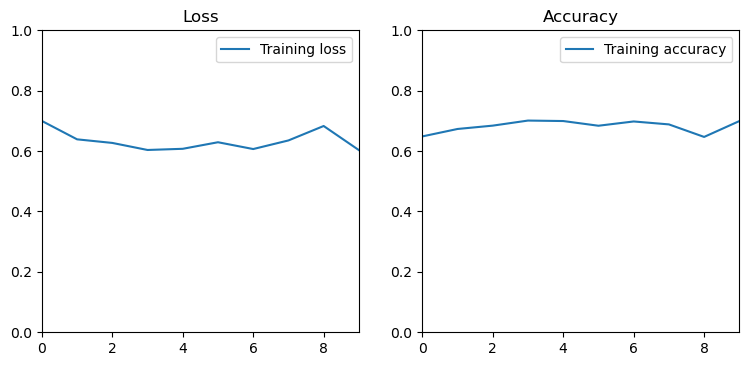

177/177 [==============================] - 1s 8ms/step - loss: 0.6032 - accuracy: 0.6993


In [25]:
N_EPOCHS = 10

plot_losses = PlotLossesSecond(n_epochs=N_EPOCHS)

model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=128, callbacks=[plot_losses])

 64/177 [=========>....................] - ETA: 0s

2023-02-19 14:55:09.128141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 1s 3ms/step


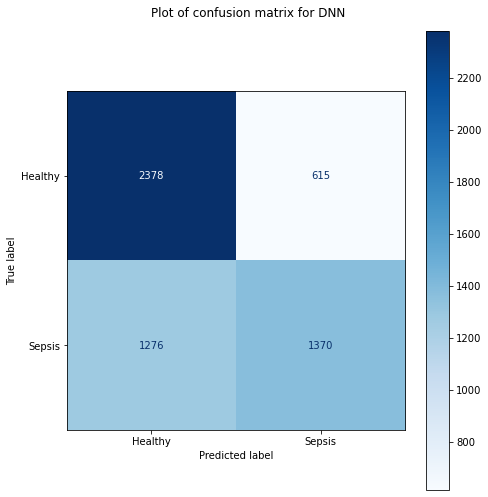

Accuracy: 0.665
Recall: 0.518
Precission: 0.690


In [11]:
test_show_metrics_dnn(model, X_test=X_test, y_test=y_test)

In [12]:
patient_predict_dnn(model)

# Tree model

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)

tree_model = DecisionTreeClassifier(random_state=1, max_depth=15)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=1)

In [6]:
def test_show_metrics_tree(tree_model, X_test, y_test, threshold=0.5, labels=['Healthy', 'Sepsis']):
    y_pred = tree_model.predict(X_test)

    threshold = 0.5
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    conf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                   display_labels=labels,
                                                   cmap=plt.cm.Blues)

    fig = conf.figure_
    fig.set_figwidth(7)
    fig.set_figheight(7)
    fig.suptitle('Plot of confusion matrix for DNN')
    fig.tight_layout()
    plt.show()

    print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: {:.3f}'.format(metrics.recall_score(y_test, y_pred)))
    print('Precission: {:.3f}'.format(metrics.precision_score(y_test, y_pred)))

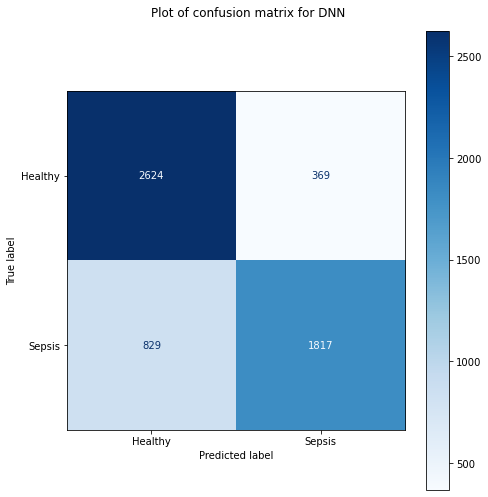

Accuracy: 0.788
Recall: 0.687
Precission: 0.831


In [7]:
test_show_metrics_tree(tree_model, X_test, y_test)

In [13]:
patient_predict_tree(tree_model)

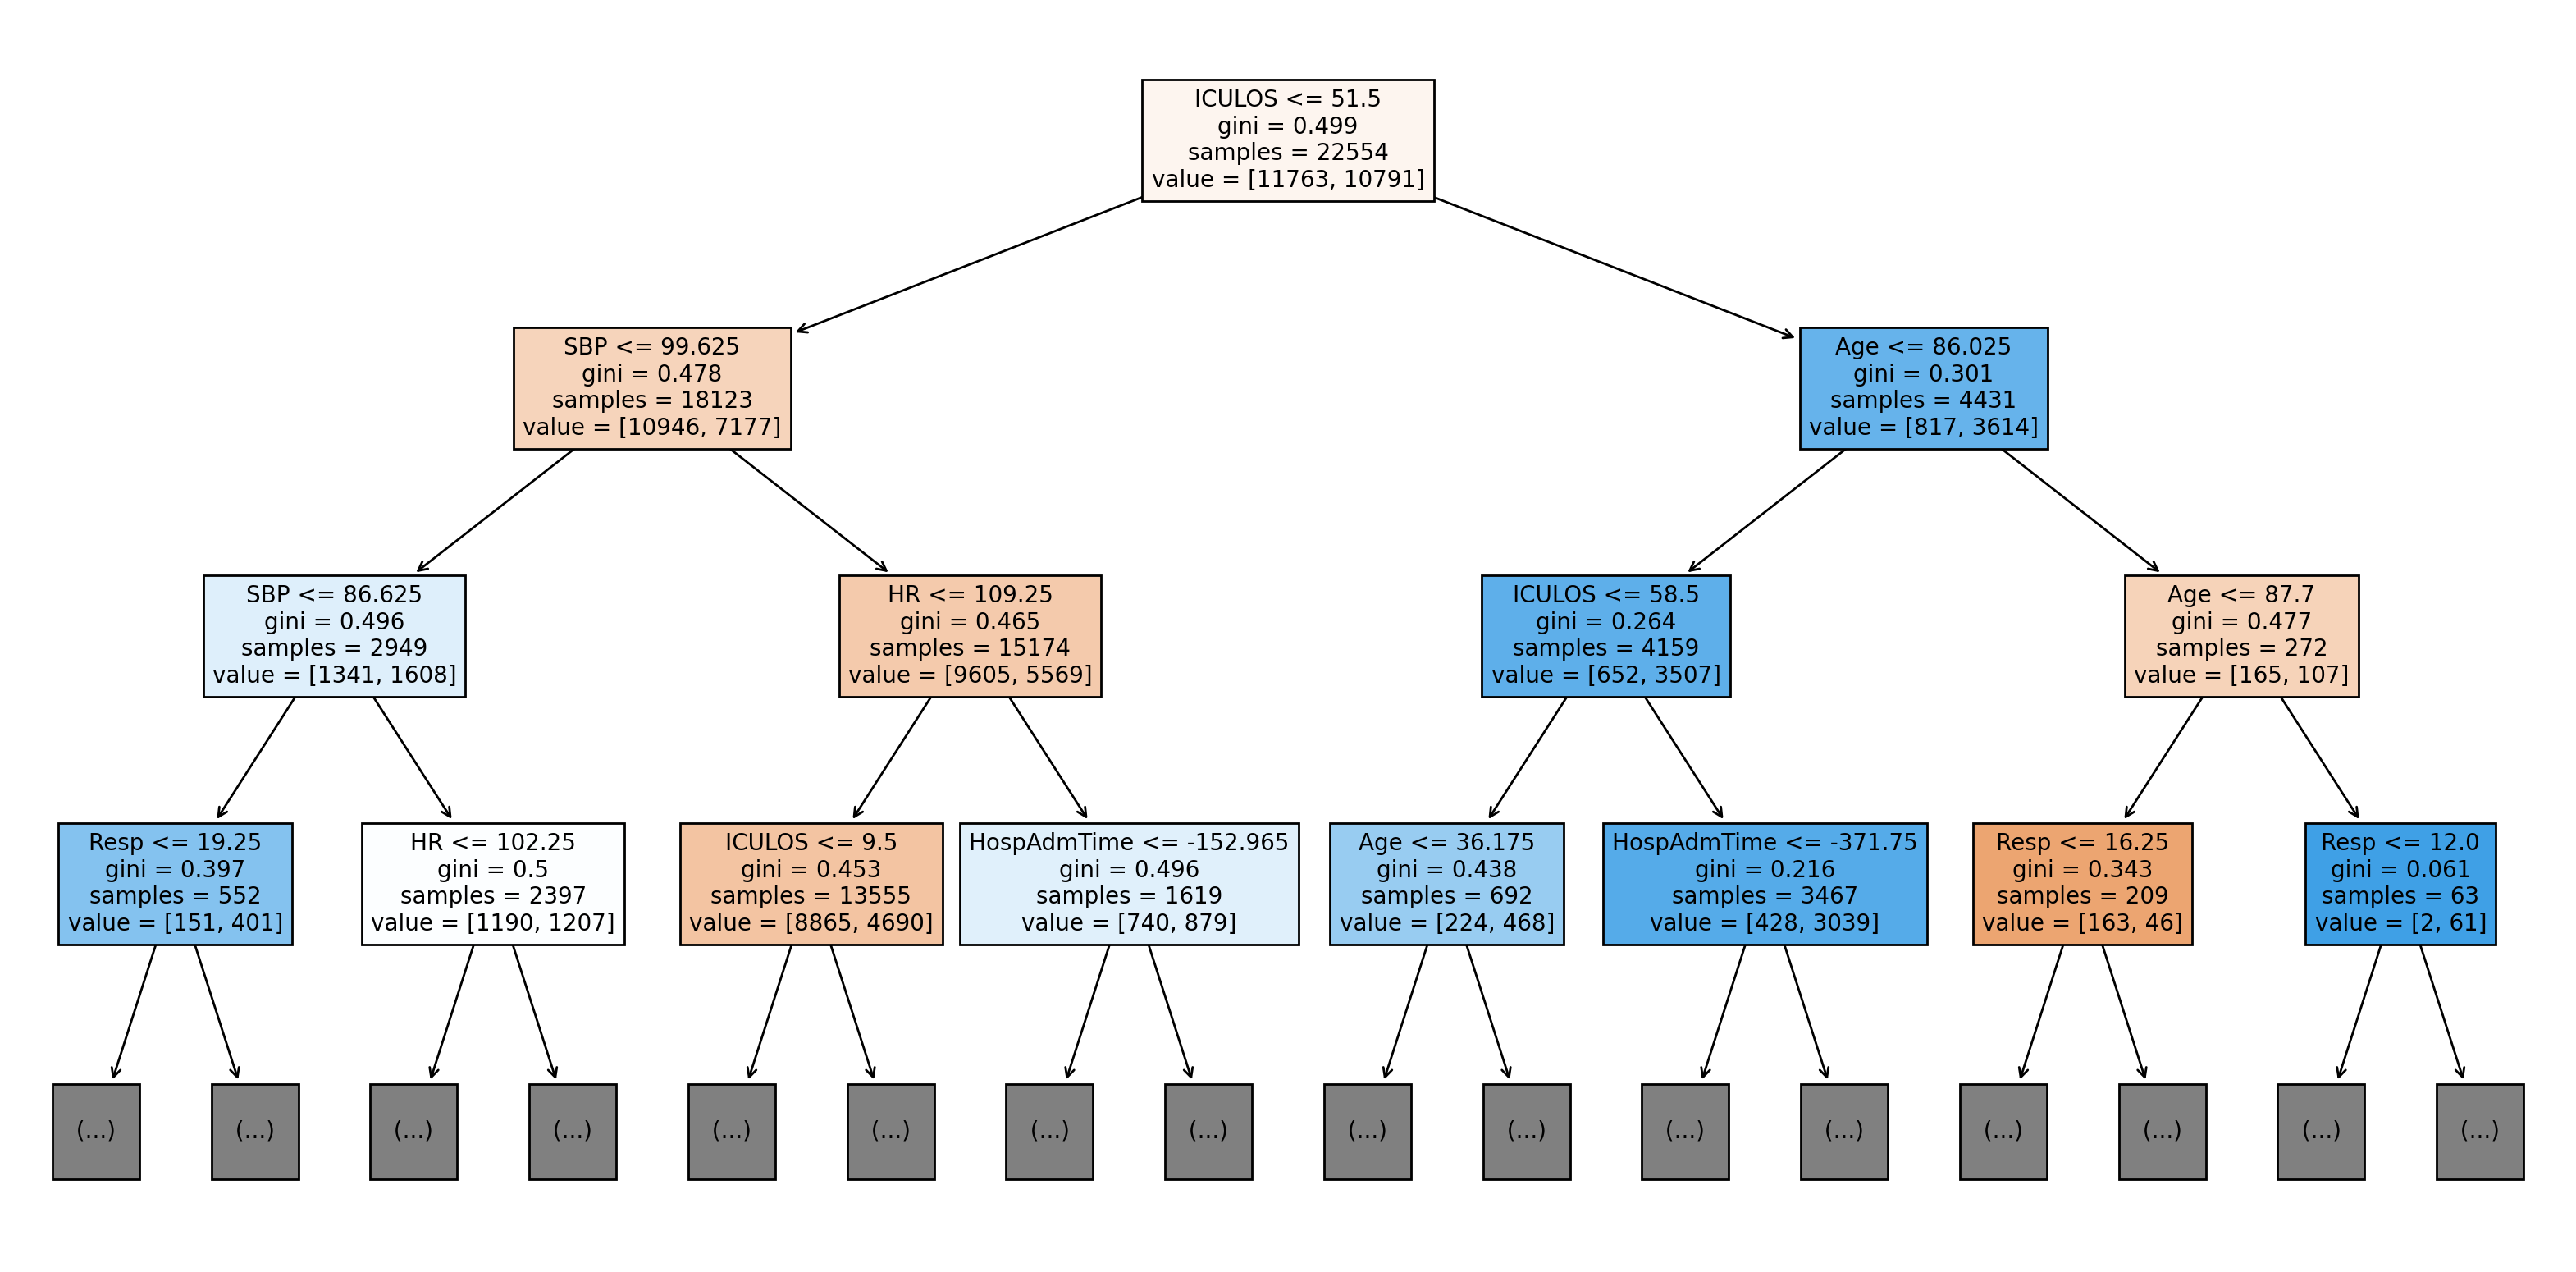

In [16]:
feature_names = X_train.columns.to_list()
class_names = ['Healthy', 'Sepsis']
fig, axs = plt.subplots(figsize=(20,10), dpi=200)
plot_tree(tree_model, max_depth=3, filled=True, feature_names=feature_names,fontsize=10)
plt.show()

In [19]:
feature_names = X_train.columns.to_list()
feature_importances = tree_model.feature_importances_

for f_name, f_imporatance in zip(feature_names, feature_importances):
  print('{} is responsible for {:.5f}% of prediction'.format(f_name,100*f_imporatance))

HR is responsible for 7.83722% of prediction
O2Sat is responsible for 2.76733% of prediction
SBP is responsible for 6.29296% of prediction
MAP is responsible for 4.77810% of prediction
Resp is responsible for 4.40141% of prediction
Age is responsible for 27.58464% of prediction
Gender is responsible for 1.37871% of prediction
HospAdmTime is responsible for 20.96336% of prediction
ICULOS is responsible for 23.99627% of prediction


In [ ]:
# img with other type of prediction

# Understanding better DNN

In [26]:
perm = PermutationImportance(model, scoring='neg_mean_absolute_error').fit(X_test,y_test)

 70/177 [==========>...................] - ETA: 0s

2023-02-19 15:12:29.535014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 0s 2ms/step


In [30]:
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0688 ± 0.0055,ICULOS
0.0234 ± 0.0032,SBP
0.0231 ± 0.0021,HR
0.0163 ± 0.0028,Age
0.0148 ± 0.0021,MAP
0.0112 ± 0.0019,Gender
0.0101 ± 0.0027,HospAdmTime
0.0080 ± 0.0008,Resp
0.0065 ± 0.0011,O2Sat


In [32]:
#from eli5.keras.explain_prediction import explain_prediction_keras

ImportError: cannot import name 'array_to_img' from 'keras.preprocessing.image' (/Users/ivojohn/opt/anaconda3/lib/python3.9/site-packages/keras/preprocessing/image.py)